In [1]:
import pandas as pd 
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np


In [2]:
%load_ext autoreload
%autoreload 2

In [25]:
from utils import *


In [26]:
import glob
import os 
from pathlib import Path


DATA_PATH = Path('./data')

if not DATA_PATH.exists():
    DATA_PATH.mkdir(parents=True, exist_ok=True)

CACHE_FILES = glob.glob('./trace/**/cache_*', recursive=True)

ADDRESS_COUNTS_PATH = DATA_PATH / 'address_counts.csv'

if not os.path.exists(ADDRESS_COUNTS_PATH):
    print("generating address counts")
    address_counts = generate_address_counts(ADDRESS_COUNTS_PATH, CACHE_FILES)
else:
    address_counts = load_series(ADDRESS_COUNTS_PATH)


In [27]:
from sklearn.cluster import KMeans

ADDRESS_CLUSTER_PATH = DATA_PATH / 'address_cluster.csv'


if not ADDRESS_CLUSTER_PATH.exists():
    addresses = address_counts.index.to_numpy().reshape(-1, 1)
    k_means = KMeans(n_clusters=6).fit(addresses)

    cluster = k_means.predict(addresses)

    address_cluster = {addresses[i][0]: cluster[i] for i in range(len(addresses)) }
    pd.Series(address_cluster).to_csv(ADDRESS_CLUSTER_PATH, header=None)
else:
    addresses = address_counts.index.to_numpy()
    address_cluster = load_series(ADDRESS_CLUSTER_PATH).to_dict()
    cluster = np.array([address_cluster[a] for a in addresses])

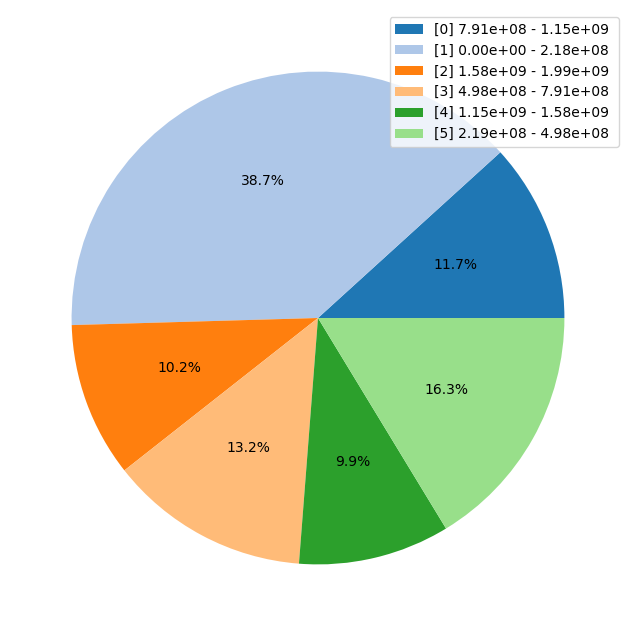

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
cluster_counts = pd.value_counts(cluster).sort_index()

cluster_addresses = {
    c: addresses[np.where(cluster == c)]
    for c in cluster_counts.index
}
labels = [
    f'[{c}] {min(cluster_addresses[c]):.2e} - {max(cluster_addresses[c]):.2e} ' 
    for c in cluster_counts.index 
]

ax.pie(
    cluster_counts, 
    autopct='%1.1f%%', 
    colors=COLORS
)
ax.legend(labels, loc='upper right')
plt.show()

[0, 218414080, 498154224, 790667536, 1146112960, 1578374656, 1985667168]


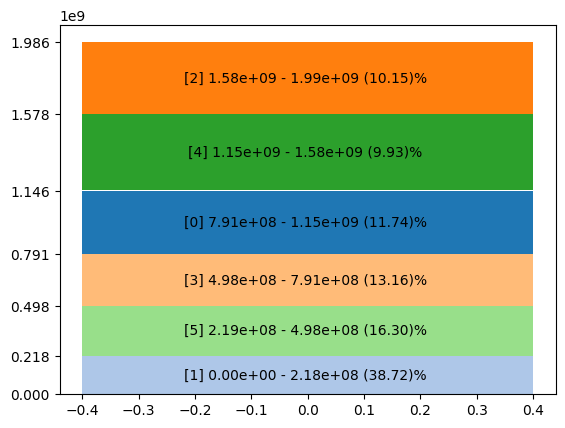

In [23]:
ticks = [0]

for c in sorted(range(6), key=lambda x: min(cluster_addresses[x])):
    height = max(cluster_addresses[c])-min(cluster_addresses[c])
    count = len(cluster_addresses[c])
    percent = count/len(addresses)*100
    plt.bar(
        [0], [height], bottom=min(cluster_addresses[c]),
        color=COLORS[c]
    )
    ticks.append(max(cluster_addresses[c]))
    plt.text(
        0, (max(cluster_addresses[c])+min(cluster_addresses[c]))/2, 
         f'[{c}] {min(cluster_addresses[c]):.2e} - {max(cluster_addresses[c]):.2e} ({percent:.2f})% ',
         ha='center', va='center'
    )

print(ticks)
plt.yticks(ticks)
plt.show()

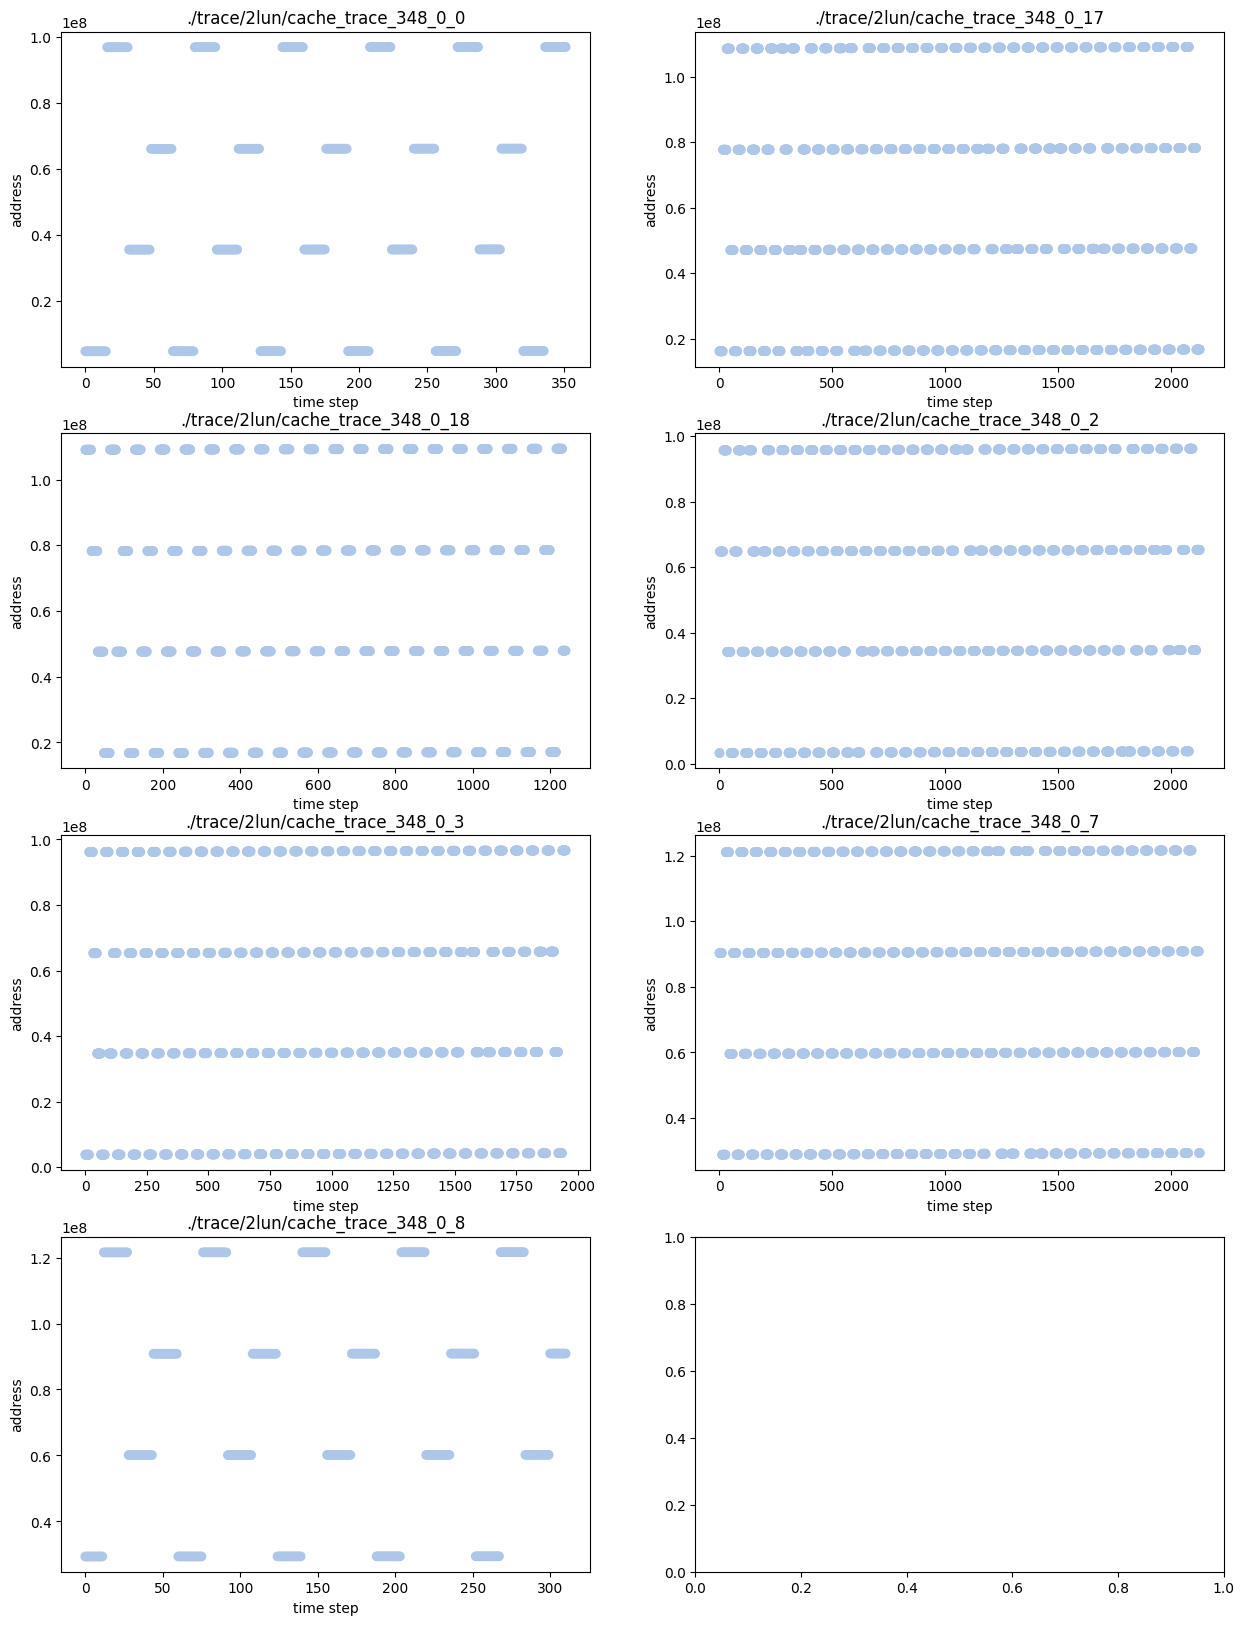

In [29]:
scatter_cache_traces(glob.glob('./trace/2lun/cache_*'), address_cluster=address_cluster)

In [76]:
import random
paths = []

gl = list(glob.glob('./trace/cache_*'))
random.shuffle(gl)
for path in gl:
    a = get_addresses(load_cache_trace(path))
    if len(a) > 65:
        paths.append(path)
    if len(paths) == 10:
        break

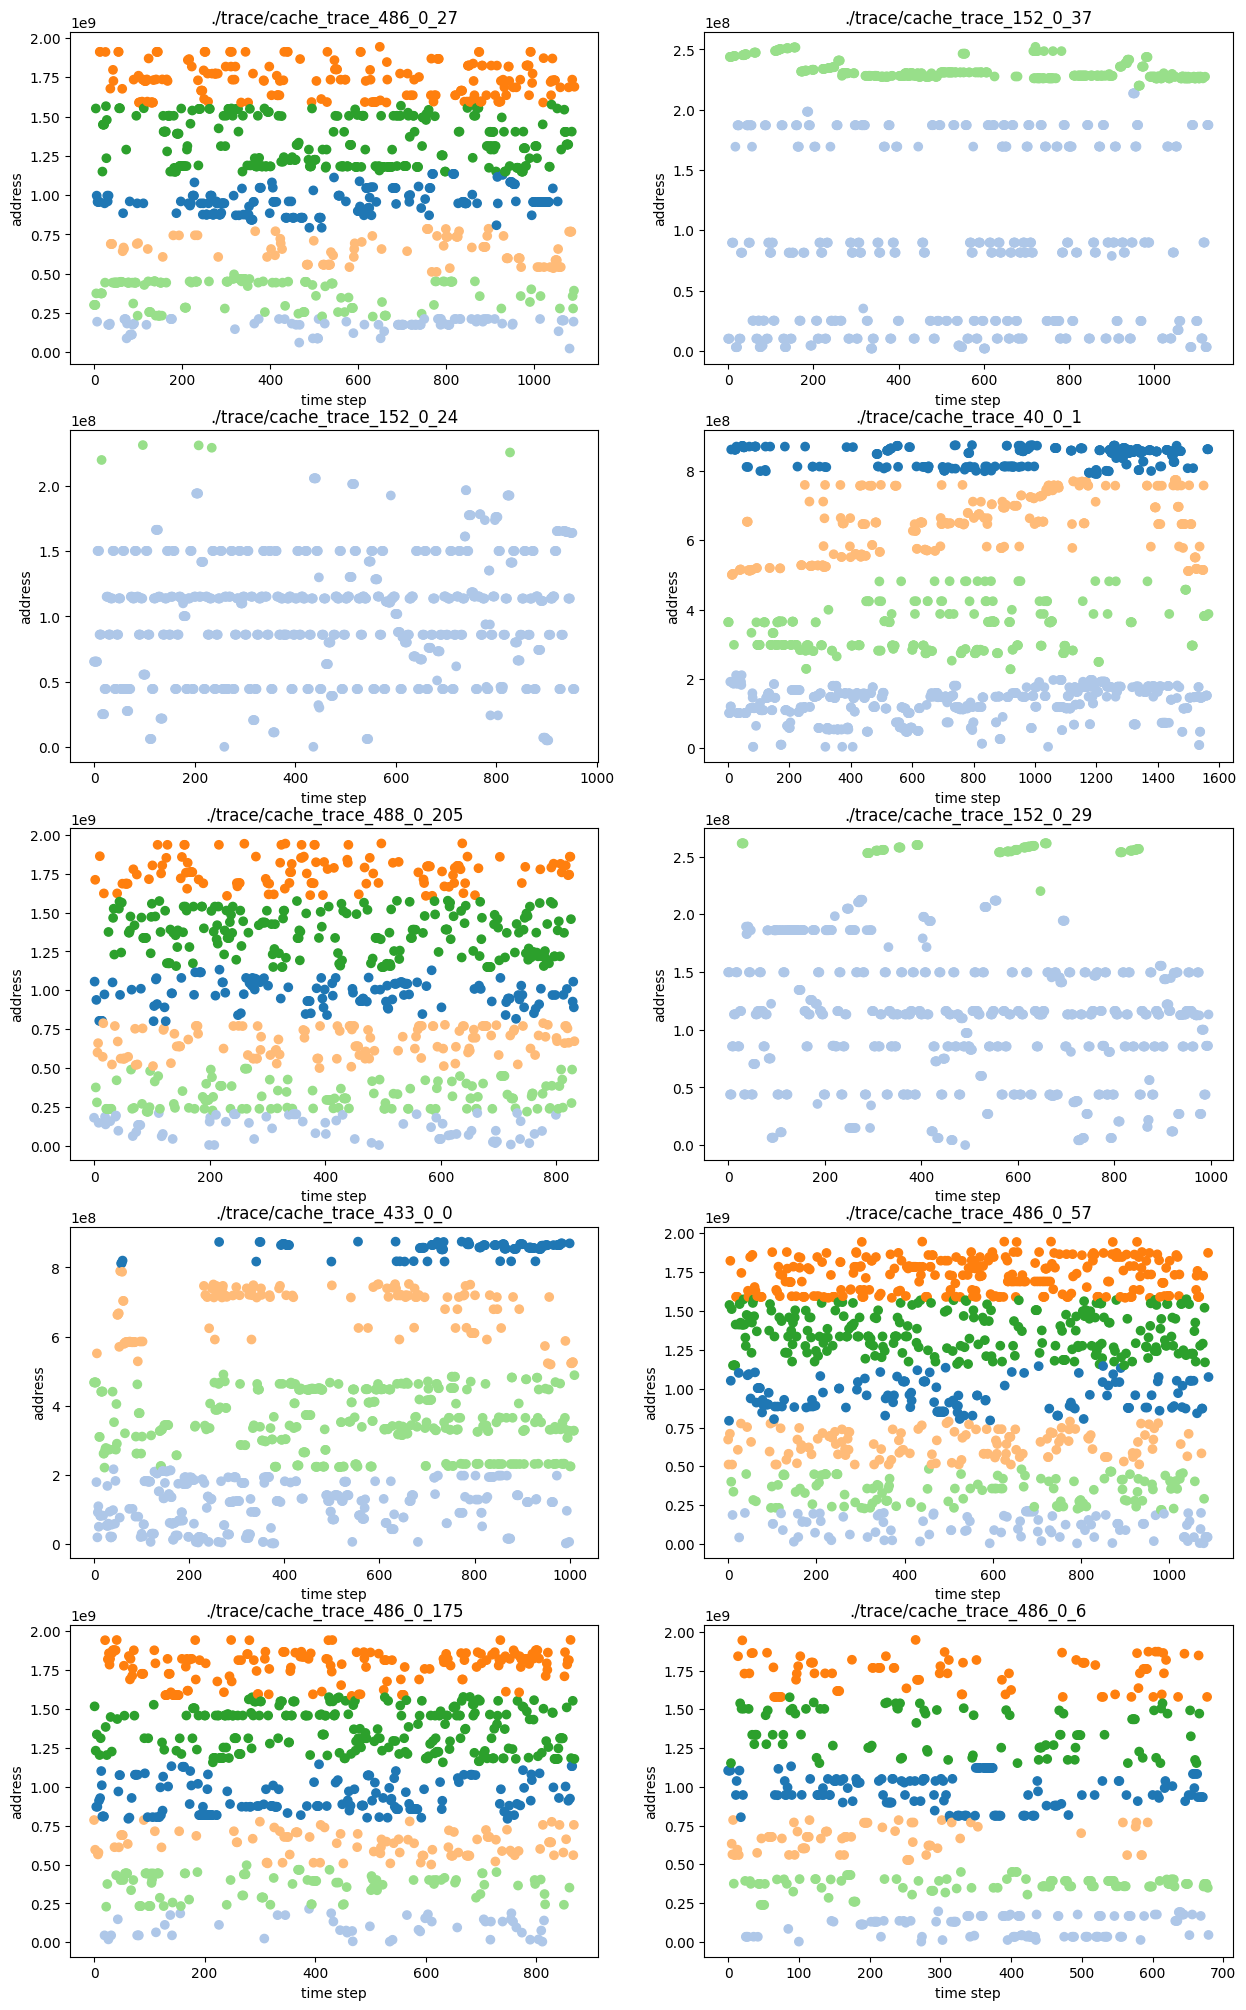

In [77]:
scatter_cache_traces(paths, address_cluster=address_cluster)

In [36]:
DELTAS_PATH = DATA_PATH / 'c_lstm'
CACHE_FILES = glob.glob('./trace/**/cache_*', recursive=True)

cluster_deltas = {}
for c in range(6):
    path = DELTAS_PATH / f'deltas_c_{c}'
    if not path.exists():
        cluster_deltas[c] = generate_deltas(
            path, CACHE_FILES, 
            address_filter_fn=lambda a: address_cluster[a] == c
        )
    else:
        cluster_deltas[c] = load_deltas(path)
        
      

In [37]:
for c in cluster_counts.index:
    train_path = DELTAS_PATH / f'train_deltas_c_{c}'
    test_path = DELTAS_PATH / f'test_deltas_c_{c}'
    generate_train_test_data(cluster_deltas[c], train_path, test_path)

In [38]:
vocabs_in_th_2 = {}
cluster_delta_counts = {}

all_deltas = []
for c in range(6):
    path = DELTAS_PATH / f'delta_counts_c_{c}'
    if not path.exists():
        cluster_delta_counts[c] = generate_delta_counts(cluster_deltas[c], path)
    else:
        cluster_delta_counts[c] = load_series(path)
        
    all_deltas += cluster_deltas[c]

DELTA_COUNTS_PATH = DELTAS_PATH / 'delta_counts'
if not DELTA_COUNTS_PATH.exists():
    delta_counts = generate_delta_counts(all_deltas, DELTA_COUNTS_PATH)
else:
    delta_counts = load_series(DELTA_COUNTS_PATH)


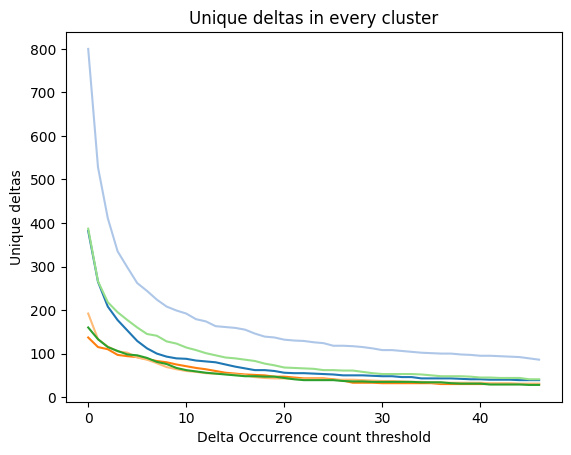

In [39]:

for c in range(6):
    sizes = []
    for i in range(3, 50):
        sizes.append(cluster_delta_counts[c][cluster_delta_counts[c] >= i].index.to_numpy().shape[0])
    
    plt.plot(sizes, color=COLORS[c])
    
plt.title('Unique deltas in every cluster')
plt.ylabel('Unique deltas')
plt.xlabel('Delta Occurrence count threshold')
plt.show()

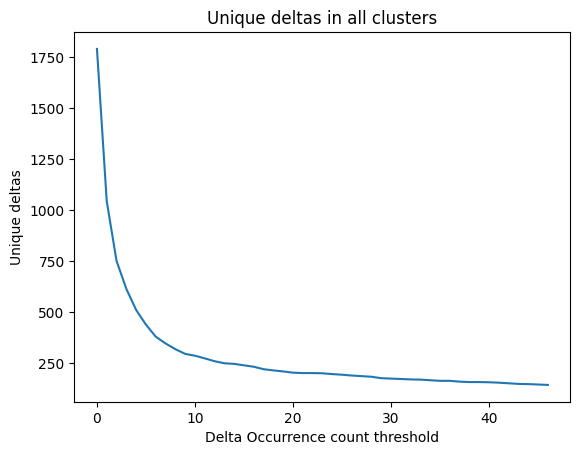

In [40]:
sizes = []
for i in range(3, 50):
    sizes.append(delta_counts[delta_counts >= i].index.to_numpy().shape[0])

plt.plot(sizes)
    
plt.title('Unique deltas in all clusters')
plt.ylabel('Unique deltas')
plt.xlabel('Delta Occurrence count threshold')
plt.show()

In [41]:
VOCABS_PATH = Path('./vocabs/c_lstm')
vocab_in_th_2 = generate_vocab(
    delta_counts, VOCABS_PATH/'vocab_in_th_2', threshold=2, with_padding=True
)

cluster_vocab_in_th_2 = {}
for c in range(6):
    cluster_vocab_in_th_2 = generate_vocab(
        cluster_delta_counts[c], VOCABS_PATH/f'vocab_in_th_2_c_{c}', threshold=2, with_padding=True
    )
    
vocab_out = generate_vocab(delta_counts, './vocabs/c_lstm/vocab_out_percent_10.json', percent=0.1, with_padding=False)
print(len(vocab_out))

22735


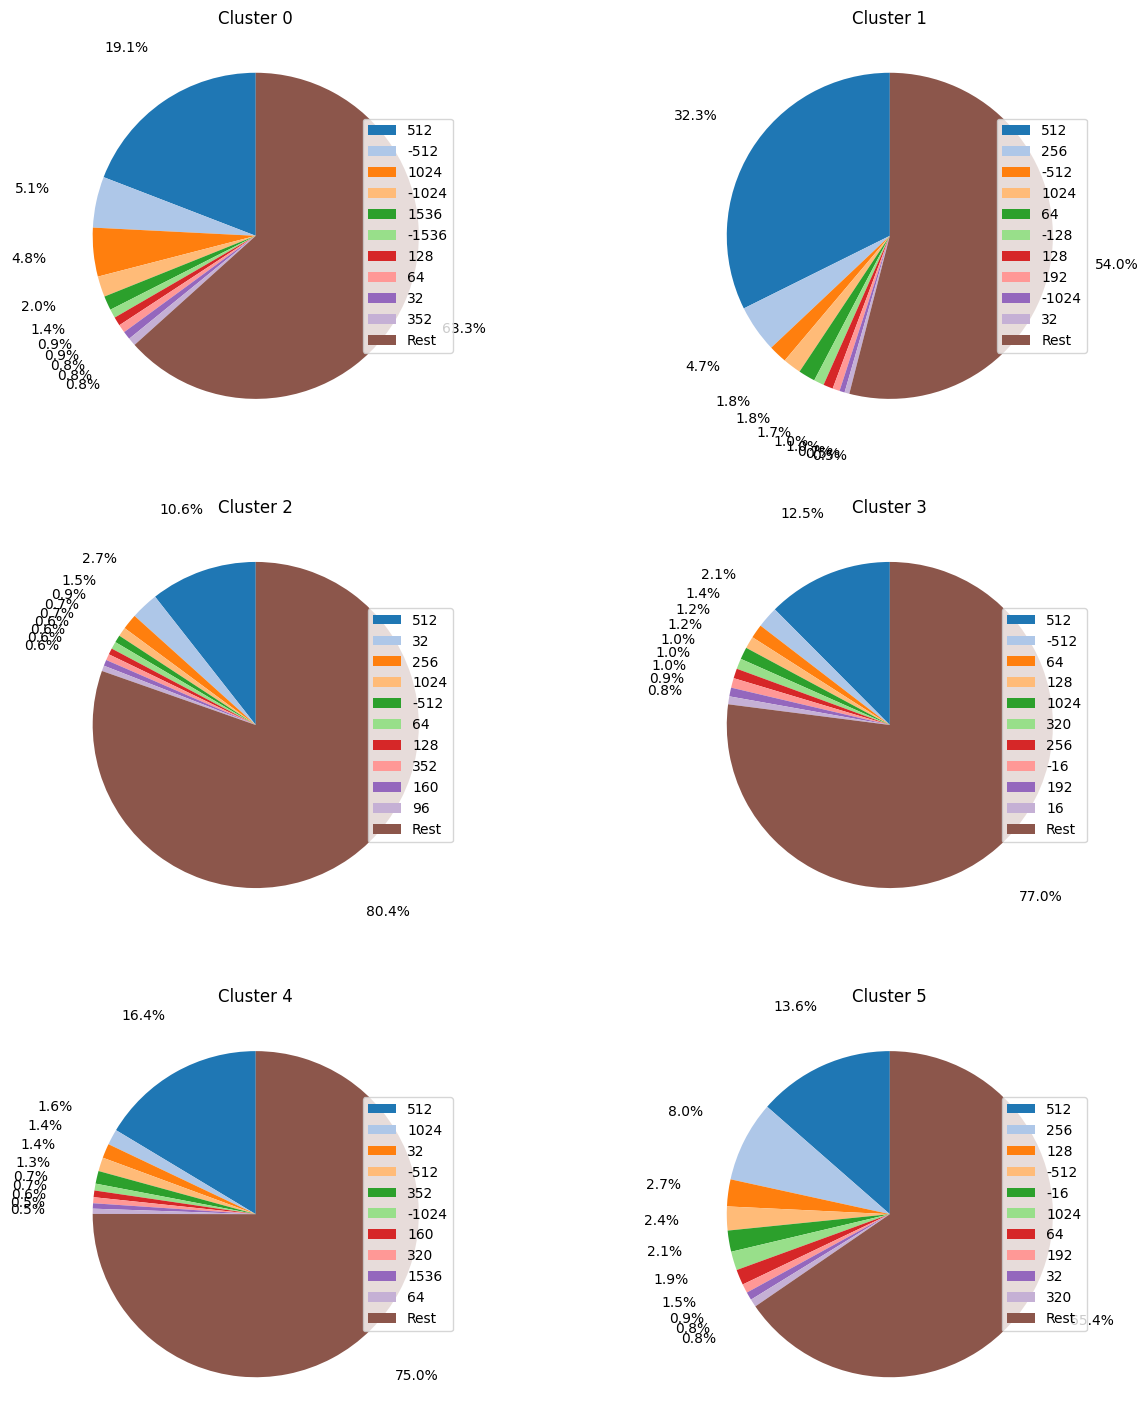

In [42]:
_, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))

for c in range(6):
    to_show = cluster_delta_counts[c].nlargest(10)
    rest = cluster_delta_counts[c].sum() - to_show.sum()

    labeldistance = 1.2
    labels = list(to_show.index)+['Rest']
    axs[c//2][c%2].pie(
        list(to_show.values)+[rest], 
        autopct='%1.1f%%', 
        labeldistance=labeldistance,
        pctdistance=1.4,
        startangle=90,
        colors=COLORS
    )
    axs[c//2][c%2].set_title(f'Cluster {c}')
    axs[c//2][c%2].legend(labels, loc='center right')
plt.show()

In [39]:

data = {
    c: load_deltas(f'./data/c_lstm/test_deltas_c_{c}')
    for c in range(6)
}


In [40]:
from top_count_model import TopCountClusterModel
top_count_model = TopCountClusterModel(cluster_delta_counts, vocab_out, 10)

100%|██████████| 1350/1350 [00:01<00:00, 872.22it/s]


Top k cluster model accuracy for n=1: 21.59%


100%|██████████| 1350/1350 [00:01<00:00, 843.29it/s]


Top k cluster model accuracy for n=2: 25.43%


100%|██████████| 1350/1350 [00:01<00:00, 770.89it/s]


Top k cluster model accuracy for n=3: 27.52%


100%|██████████| 1350/1350 [00:01<00:00, 842.28it/s]


Top k cluster model accuracy for n=4: 29.48%


100%|██████████| 1350/1350 [00:01<00:00, 1035.39it/s]


Top k cluster model accuracy for n=5: 31.11%


100%|██████████| 1350/1350 [00:01<00:00, 1062.80it/s]


Top k cluster model accuracy for n=6: 32.53%


100%|██████████| 1350/1350 [00:01<00:00, 978.55it/s]


Top k cluster model accuracy for n=7: 33.41%


100%|██████████| 1350/1350 [00:01<00:00, 935.31it/s]


Top k cluster model accuracy for n=8: 34.21%


100%|██████████| 1350/1350 [00:01<00:00, 836.12it/s]


Top k cluster model accuracy for n=9: 34.84%


100%|██████████| 1350/1350 [00:01<00:00, 861.97it/s]


Top k cluster model accuracy for n=10: 35.41%


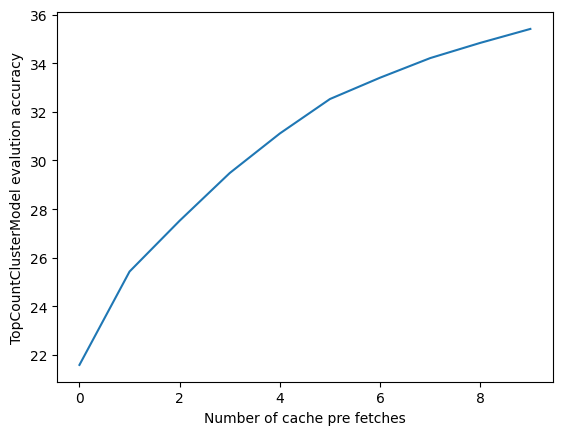

In [41]:
n_acc = []
for n in range(1, 11):    
    _, acc = cluster_evaluate(top_count_model, data, vocab_out, n=n)
    n_acc.append(acc)
    print(f"Top k cluster model accuracy for n={n}: {acc:.2f}%")

plt.plot(n_acc)
plt.xlabel('Number of cache pre fetches')
plt.ylabel('TopCountClusterModel evalution accuracy')
plt.show()


In [44]:
from clustering_lstm import ClusteringLSTM
model = ClusteringLSTM.load('./experiments/c_lstm/num_epochs_10_dropout_08/0/model.pt')

Batch size 2


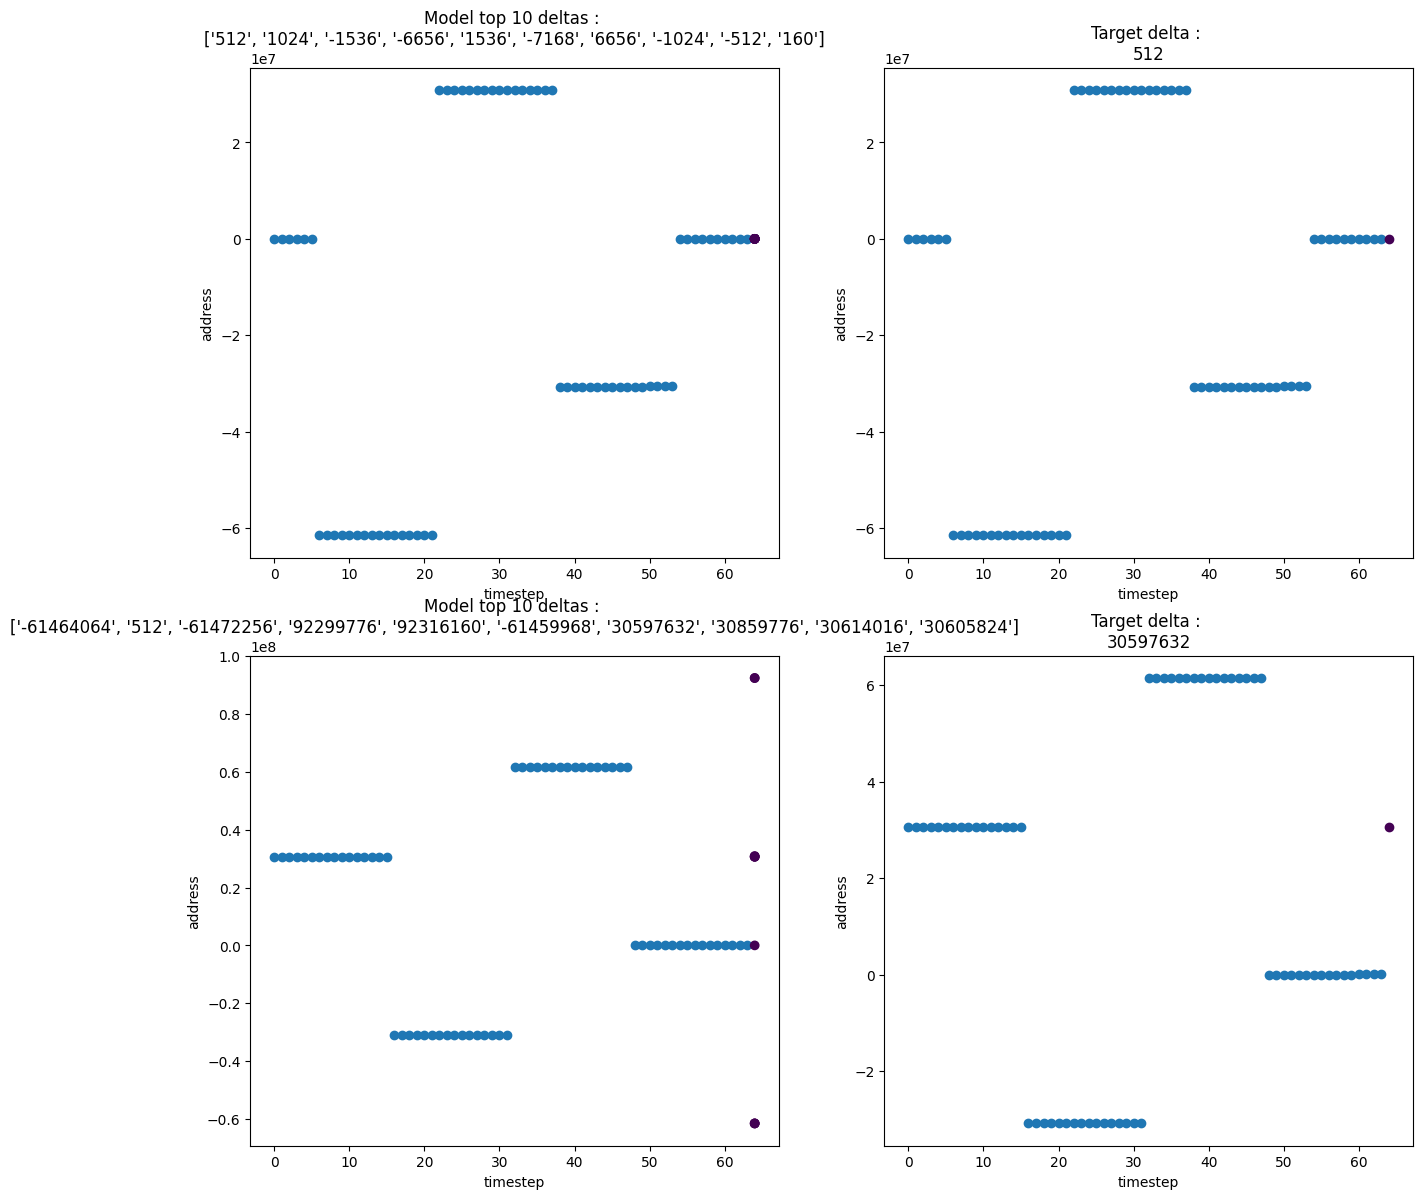

  0%|          | 0/144 [00:00<?, ?it/s]


In [81]:
path = './trace/2lun/cache_trace_348_0_0'
file_deltas = {
    c: [get_deltas(load_cache_trace(path), lambda a: address_cluster[a] == c)]
    for c in range(6)
}
scatter_cluster_data_results(file_deltas, model, 1, model.vocab_out, batches=2)